In [5]:
import numpy as np
import matplotlib.pyplot as plt


# %autoreload 2

import pandas as pd
import tqdm.notebook as tqdm
from multiprocessing import Pool
import seaborn as sns
import subprocess
import os
import pickle
import json 

import py.data_gen as data_gen
import py.algos as algos

# IMPORTANT: will use 100 CORES of the CPU
N_CORES = 100 
# experiment directory to load data from, in case not running the algorithm.
exp_dir_load = 'experiments/8451b26'

plt.rcParams.update({'font.size': 18})

In [6]:
# some helper functions 
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
  
def save_runs(exp_root, exp_name, runs, args):
    git_hash = algos.get_git_revision_hash()
    dirty = b'script.py' in subprocess.check_output(['git', 'diff', '--name-only'])
    exp_root = os.path.join(exp_root, f'{git_hash}-dirty' if dirty else f'{git_hash}')
    exp_dir = os.path.join(exp_root, exp_name)
    os.makedirs(exp_dir)
    with open(os.path.join(exp_dir, 'results'), 'wb') as f:
        pickle.dump(runs, f)
    with open(os.path.join(exp_dir, 'args' ), 'w') as f:
        json.dump(vars(args), f, indent=True, sort_keys=True, cls=NumpyEncoder)

def get_accepted_per_round(_runs, n_rounds):
  _list1 = []
  for _r in _runs:
    accepted_per_round = np.array(np.array_split(_r, n_rounds)).sum(axis=-1)
    rejected_per_round = 1 - accepted_per_round
    _list1.append(accepted_per_round)
  accepted_per_round = np.concatenate(_list1)
  return accepted_per_round

## harris et. al setup with selection

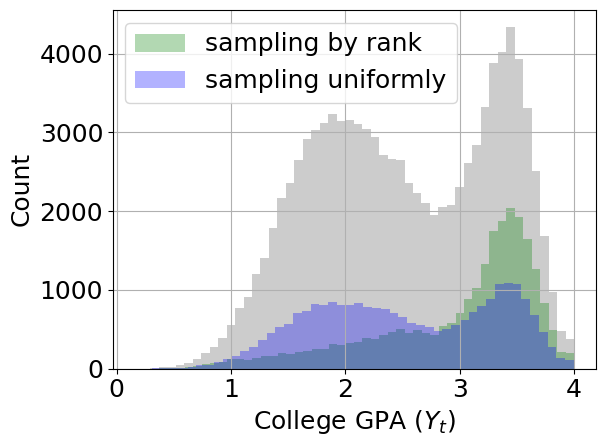

In [8]:
# plot data.
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --envs-accept-rates .25 --rank-type uniform'
args = algos.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )

cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --envs-accept-rates .25 --rank-type prediction'
args = algos.get_args(cmd)
np.random.seed(1)
b,x,y2,EW,theta, w, z2, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )
fig,ax=plt.subplots()
plt.hist(y2[0], alpha=.2 , color='k', bins=50)
plt.hist(y2[0][z2==1], color='g', bins=50, alpha=.3, label='sampling by rank')
plt.hist(y[0][z==1], color='b', bins=50, alpha=.3, label='sampling uniformly')
ax.grid()
ax.set_xlabel('College GPA ($Y_t$)')
ax.set_ylabel('Count')
ax.legend () 

# assert np.all (y2[0] ==y[0] )
plt.tight_layout()
plt.savefig('figures/haris-et-al-selection-dist.pdf')

### <font color='red'>compute cell</font>

In [9]:
n_runs = 50  
# ranking selection
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --methods ols 2sls --envs-accept-rate .25 --rank-type prediction'
args = algos.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(N_CORES) as p:
    runs = p.starmap(algos.run_multi_env, args_list )
runs = [r[0] for r in runs]

# uniform sampling
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --methods ols 2sls --envs-accept-rate .25 --rank-type uniform'
args = algos.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(N_CORES) as p:
    runs2 = p.starmap(algos.run_multi_env, args_list )
runs2 = [r[0] for r in runs2]

# saving stuff.
try:
  save_runs('experiments', 'harris-with-selection', (runs, runs2), args)
except FileExistsError:
  pass

99it [00:00, 108.13it/s]
99it [00:00, 135.34it/s]
66it [00:00, 120.02it/s]
99it [00:00, 102.78it/s]
99it [00:00, 144.73it/s]


99it [00:00, 111.63it/s]
99it [00:00, 103.08it/s]
61it [00:00, 193.63it/s]
99it [00:00, 110.79it/s]
99it [00:00, 165.23it/s]
99it [00:00, 130.70it/s]

92it [00:00, 148.25it/s]
99it [00:00, 124.30it/s]
79it [00:00, 196.52it/s]
97it [00:00, 93.15it/s]]
99it [00:00, 118.93it/s]
99it [00:01, 98.45it/s]]

99it [00:00, 115.12it/s]
83it [00:00, 181.95it/s]
99it [00:00, 140.61it/s]
98it [00:00, 124.14it/s]
99it [00:00, 135.27it/s]


99it [00:00, 141.82it/s]

99it [00:00, 189.88it/s]
99it [00:00, 197.12it/s]

99it [00:00, 113.93it/s]
99it [00:00, 185.90it/s]
99it [00:00, 181.69it/s]
99it [00:00, 127.01it/s]
99it [00:00, 169.34it/s]
99it [00:00, 195.14it/s]
99it [00:00, 193.40it/s]
99it [00:00, 179.47it/s]
91it [00:00, 169.85it/s]
99it [00:00, 185.11it/s]

99it [00:00, 186.25it/s]
99it [00:00, 201.52it/s]
99it [00:00, 188.58it/s]
99it [00:00, 220.12it/s]
99it [00:00, 171

### <font color='blue'>load cell</font>

In [6]:
# loading saved stuff
with open(os.path.join(exp_dir_load, 'harris-with-selection', 'results'), 'rb') as f:
  runs = pickle.load(f)
  runs, runs2 = runs

FileNotFoundError: [Errno 2] No such file or directory: 'experiments/8451b262/harris-with-selection/results'

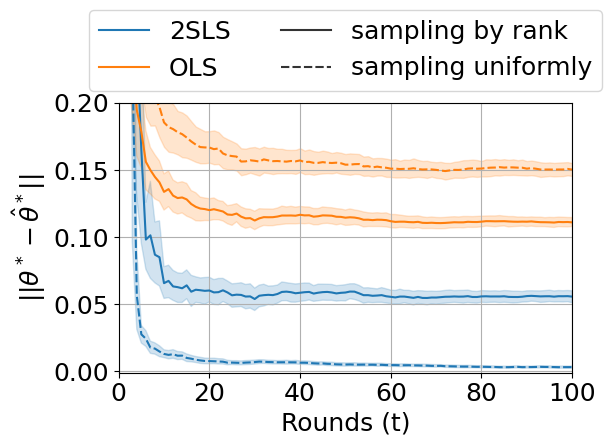

In [10]:
df = algos.runs2df(runs)
df['sampling'] = 'sampling by rank'
df2 = algos.runs2df(runs2)
df2['sampling'] = 'sampling uniformly'
df = pd.concat((df, df2 ))
# converting to long format.
# df = script.runs2df(runs)
dflong = pd.melt(df, id_vars=('iterations', 'sampling'), value_vars=('ols_env0', '2sls_env0'), var_name='method', value_name='error')
dflong['method'] = dflong['method'].astype('category')
dflong['method']= dflong['method'].cat.rename_categories({'ols_env0':'OLS', '2sls_env0': '2SLS'})

dflong['iterations'] = dflong['iterations']+2
# plot
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', style='sampling', ax=ax)
ax.set_ylim(bottom=-0.001, top=0.2)
ax.legend(loc='upper right')
ax.set_ylabel(r'$||\theta^* - \hat{\theta}^*|| $')
ax.set_xlabel('Rounds (t)')
ax.grid()
ax.set_xlim((0, 100))
handles, labels = ax.get_legend_handles_labels()
handles =  [handles[1], handles[2], handles[4], handles[5]]
labels =  [labels[1], labels[2], labels[4], labels[5]]
ax.legend(handles=handles, labels=labels, ncol=2, loc='lower center', bbox_to_anchor=(0.25, 1, .5, .5))

plt.tight_layout()
plt.savefig('figures/harris-et-al-selection-results.pdf')

## our setup.

In [11]:
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours --envs-accept-rate .5'

args = algos.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )

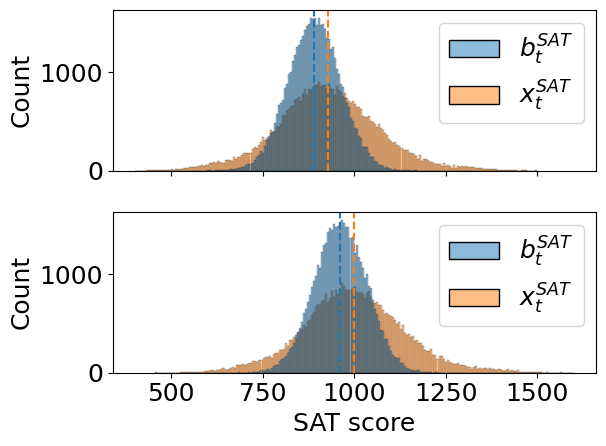

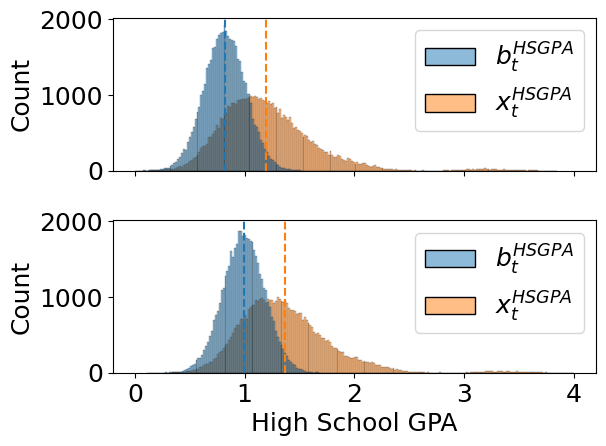

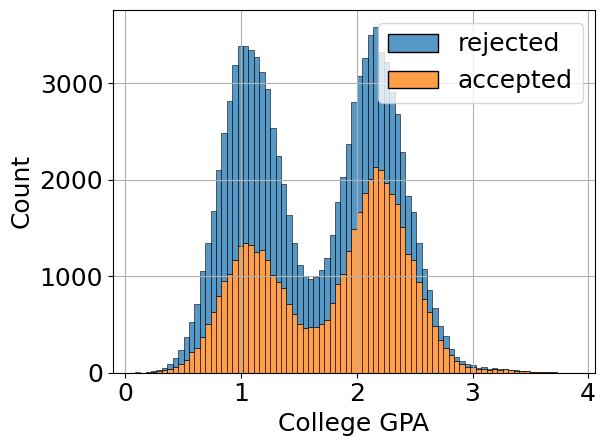

In [12]:
# dataframe with disadvantaged students.
df0 = pd.DataFrame({
    r'$b_t^{SAT}$': b[disadv_idx,0],
    r'$b_t^{HS GPA}$': b[disadv_idx,1],
    r'$x_t^{SAT}$': x[disadv_idx,0],
    r'$x_t^{HS GPA}$': x[disadv_idx,1],
    'status': z[disadv_idx],
    'y': y[0, disadv_idx],
    'y_hat': y_hat[0, disadv_idx]
    })

# dataframe with advantaged students.
df1 = pd.DataFrame({
    r'$b_t^{SAT}$': b[adv_idx,0],
    r'$b_t^{HS GPA}$': b[adv_idx,1], 
    r'$x_t^{SAT}$': x[adv_idx, 0],
    r'$x_t^{HS GPA}$': x[adv_idx, 1],
    'status': z[adv_idx],
    'y': y[0, adv_idx],
    'y_hat': y_hat[0, adv_idx]
    })

df0['class'] = 'disadv'
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df['status'] = df.status.astype('category').cat.rename_categories({0.0:'rejected', 1.0: 'accepted'})
df['status']

# SAT score
dflong = pd.melt(df, id_vars=('class'), value_vars=(r'$b_t^{SAT}$', r'$x_t^{SAT}$'), var_name='time', value_name='score')
dflong 

fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
g = sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
g.legend_.set_title(None)
g = sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])
g.legend_.set_title(None)
ax[1].set_xlabel('SAT score')


# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$b_t^{SAT}$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$x_t^{SAT}$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$b_t^{SAT}$')].score.mean(), color=sns.color_palette()[0],  linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$x_t^{SAT}$')].score.mean(), color=sns.color_palette()[1],  linestyle='--')

plt.tight_layout()
plt.savefig('figures/our-settings-data1.png')


# GPA
dflong = pd.melt(df, id_vars=('class'), value_vars=(r'$b_t^{HS GPA}$', r'$x_t^{HS GPA}$'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
g = sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
g.legend_.set_title(None)
g = sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])
g.legend_.set_title(None)
ax[1].set_xlabel('High School GPA')

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$b_t^{HS GPA}$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$x_t^{HS GPA}$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$b_t^{HS GPA}$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$x_t^{HS GPA}$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

plt.tight_layout()
plt.savefig('figures/our-settings-data2.png')

# dfa, dfr = pd.DataFrame({'y': y[0][z==1]}), pd.DataFrame({'y': y[0][z==0]})
# df = pd.concat((dfa, dfr))
fig,ax=plt.subplots()
g = sns.histplot(df, x='y', hue='status', ax=ax, multiple='stack')
g.legend_.set_title(None)
ax.set_xlabel('College GPA')
ax.grid()

plt.tight_layout()
plt.savefig('figures/our-settings-data3.pdf')

### <font color='red'>compute cell</font>

In [10]:
n_runs =50 
args = algos.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(N_CORES) as p:
    runs = p.starmap(algos.run_multi_env, args_list )
    # _runs = [r[2] for r in runs]
runs = [r[0] for r in runs]

# saving stuff. 
try:
  save_runs('experiments', 'our-settings-single-env', runs, args)
except FileExistsError:
  pass 

99it [00:09, 10.34it/s]
99it [00:09, 10.29it/s]
99it [00:09, 10.44it/s]
99it [00:09, 10.12it/s]
93it [00:09,  4.40it/s]
99it [00:10,  9.18it/s]
99it [00:10,  9.59it/s]
94it [00:10,  4.35it/s]
99it [00:10,  9.61it/s]
99it [00:10,  9.29it/s]
99it [00:10,  9.52it/s]
99it [00:10,  9.20it/s]
99it [00:10,  9.49it/s]
99it [00:11,  8.73it/s]
99it [00:10,  9.63it/s]
99it [00:10,  9.46it/s]
99it [00:10,  9.67it/s]
99it [00:11,  8.81it/s]
99it [00:11,  8.70it/s]
99it [00:10,  9.28it/s]
99it [00:10,  9.30it/s]
99it [00:11,  8.41it/s]
99it [00:11,  8.41it/s]
99it [00:10,  9.47it/s]
99it [00:10,  9.34it/s]
99it [00:11,  8.67it/s]
99it [00:11,  8.88it/s]
99it [00:10,  9.11it/s]
99it [00:11,  8.30it/s]
99it [00:11,  8.38it/s]

99it [00:11,  8.45it/s]
99it [00:12,  8.09it/s]
99it [00:11,  8.38it/s]
99it [00:11,  8.36it/s]
99it [00:11,  8.36it/s]
99it [00:11,  8.29it/s]
99it [00:12,  8.22it/s]
99it [00:12,  4.25it/s]
99it [00:12,  8.09it/s]
99it [00:11,  8.51it/s]
99it [00:12,  8.03it/s]
99it [00:12,  8


### <font color='blue'>load cell</font>

In [19]:
# loading saved stuff
with open(os.path.join(exp_dir_load, 'our-settings-single-env', 'results'), 'rb') as f:
  runs = pickle.load(f)
runs 
df2 = algos.runs2df(runs)
df = df2 

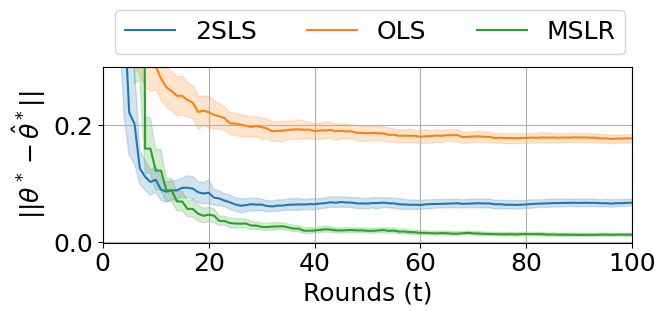

In [20]:
df = algos.runs2df(runs)
# long format for plotting
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong 
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong['method'] = dflong['method'].astype('category')
dflong['method'] = dflong['method'].cat.rename_categories({'ours': 'MSLR', 'ols': 'OLS', '2sls': '2SLS'})
dflong
dflong_stack = dflong # remember for later. 
dflong_stack['iterations'] = dflong_stack['iterations']+2
dflong_stack 
plt.rcParams.update({'font.size': 18})
fig,ax=plt.subplots(figsize=(7,3.5))
sns.lineplot(dflong_stack, x='iterations', y='error', errorbar=('ci', 95), ax=ax, hue='method',
             markers={'MSLR': '^', 'OLS': 'X', '2SLS': 'o'}, markevery=10, markersize=9)
ax.grid()
ax.set_ylim(bottom=-0.001, top=.3)
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}^* || $')
ax.set_xlabel('Rounds (t)')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], ncol=3, loc='lower left', bbox_to_anchor=(0, 1, .5, .5))
ax.set_xlim((0, 100))
plt.tight_layout()
plt.savefig('figures/our-settings-single-env.pdf')

### <font color='red'>compute cell</font>

In [13]:
## selection function variation. 
n_envs = 1
dfs = []
df_w = []
df_z = []
for env0_accept_rate in (.2, .4, .6, .8, 1.):
    cmd =f'--num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours --offline-eval --envs-accept-rates {env0_accept_rate}'
    args = algos.get_args(cmd)

    n_runs = 10
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(N_CORES) as p:
        runs_data = p.starmap(algos.run_multi_env, args_list )
    
    # recording errors
    runs = [r[0] for r in runs_data]
    df = algos.runs2df(runs)
    df['env0_accept_rate'] = env0_accept_rate
    dfs.append(df)
    
    # recording z
    runs_z = [r[2] for r in runs_data]
    accepted_per_round = get_accepted_per_round(runs_z, args.num_applicants / args.applicants_per_round)
    df = pd.DataFrame({'accepted_per_round': accepted_per_round, 'env0_accept_rate': env0_accept_rate})
    df['rejected_per_round'] = args.applicants_per_round - df['accepted_per_round']
    df_z.append(df)

df = pd.concat(dfs)
# df_w = pd.concat(df_w)
df_z = pd.concat(df_z)
value_vars = [f'{m}_env{ei}' for m in args.methods for ei in range(args.num_envs)]
value_vars
dflong = pd.melt(df, id_vars='env0_accept_rate', value_vars=value_vars, value_name='error', var_name='method_env')
dflong['method'] = dflong.method_env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.method_env.apply(lambda x:x.split('_')[-1])  

try:
    save_runs('experiments', 'our-settings-single-env-ablation', dflong, args)
except FileExistsError:
    pass

1it [00:03,  3.24s/it]
1it [00:03,  3.17s/it]
1it [00:03,  3.31s/it]

1it [00:03,  3.24s/it]
1it [00:03,  3.19s/it]
1it [00:03,  3.19s/it]
1it [00:03,  3.16s/it]
1it [00:03,  3.18s/it]
1it [00:03,  3.13s/it]
1it [00:04,  4.38s/it]
1it [00:04,  4.36s/it]
1it [00:04,  4.38s/it]

1it [00:04,  4.40s/it]
1it [00:04,  4.34s/it]
1it [00:04,  4.32s/it]
1it [00:04,  4.29s/it]
1it [00:04,  4.30s/it]
1it [00:04,  4.47s/it]
1it [00:05,  5.51s/it]
1it [00:05,  5.52s/it]
1it [00:05,  5.52s/it]
1it [00:05,  5.43s/it]
1it [00:05,  5.59s/it]
1it [00:05,  5.60s/it]
1it [00:05,  5.52s/it]
1it [00:05,  5.52s/it]
1it [00:05,  5.48s/it]
1it [00:05,  5.60s/it]
1it [00:06,  6.68s/it]
1it [00:06,  6.68s/it]
1it [00:06,  6.64s/it]
1it [00:06,  6.72s/it]
1it [00:06,  6.66s/it]
1it [00:06,  6.84s/it]
1it [00:06,  6.69s/it]
1it [00:06,  6.73s/it]
1it [00:07,  7.03s/it]
1it [00:06,  6.75s/it]
1it [00:07,  7.92s/it]
1it [00:07,  7.87s/it]
1it [00:07,  7.88s/it]
1it [00:07,  7.91s/it]
1it [00:07,  7.87s/it]
1it [00:0

### <font color='blue'>load cell</font>

In [21]:
with open(os.path.join(exp_dir_load, 'our-settings-single-env-ablation', 'results'), 'rb') as f:
    dflong = pickle.load(f)

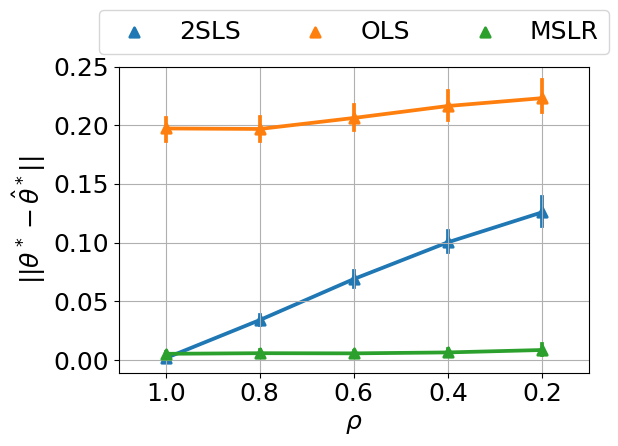

In [15]:
dflong
fig,ax=plt.subplots() 
dflong['method'] = dflong['method'].astype('category')
dflong['method'] = dflong['method'].cat.rename_categories({'2sls': '2SLS', 'ols': 'OLS', 'ours': 'MSLR'})
sns.pointplot(data=dflong[dflong.env=='env0'], x='env0_accept_rate', y='error', hue='method', markers='^')
ax.grid() 

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], ncol=3, loc='lower center', bbox_to_anchor=(0.5, 1))

ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}^*|| $')
plt.tight_layout()
ax.invert_xaxis () 
plt.savefig('figures/our-setttings-single-env-ablation.pdf')

## our setup (multiple envs.)

In [23]:
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs 2 --theta-star-std 0.1 --envs-accept-rate .5 .5 --num-cooperative-envs 2'
args = algos.get_args(cmd)
np.random.seed(3)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )

1.6502210708204164
1.716850435185807
1.8170594956638126


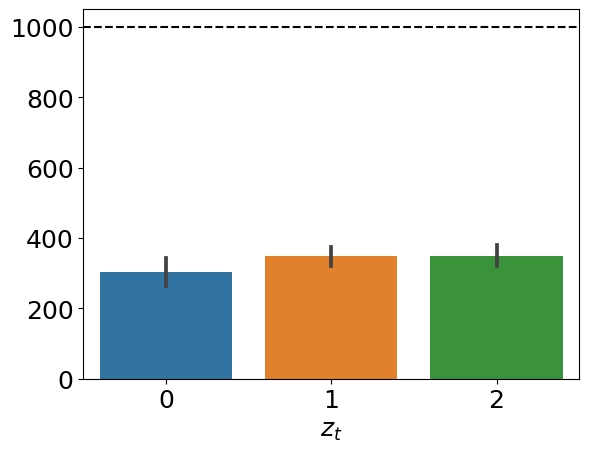

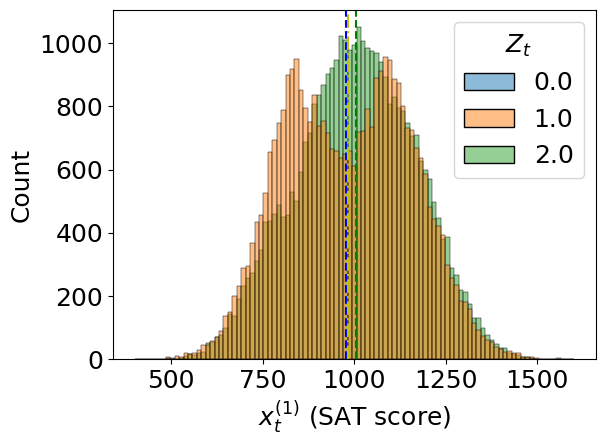

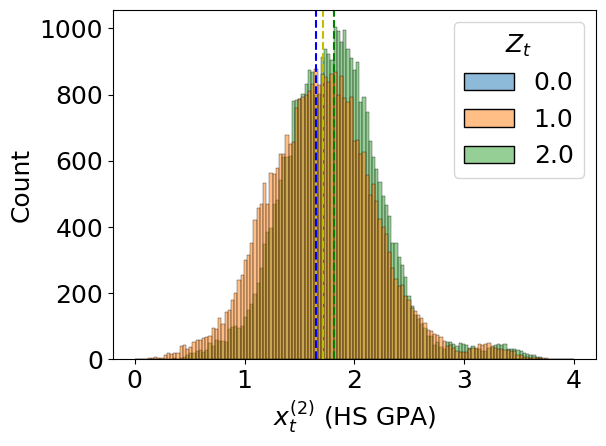

In [24]:
def add_envs(d, idx, var, prefix): 
    d.update({
        f'{prefix}_env{env_idx}': var[env_idx, idx] for env_idx in range(args.num_envs)
    })
    return d

# disadvantage class
df0 = {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]}
df0 = add_envs(df0, disadv_idx, y, 'y')
df0 = add_envs(df0, disadv_idx, w, 'w')
df0.keys() 

df0 = pd.DataFrame(df0)
df0['class'] = 'disadv'

# advantaged class
df1 = {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx],'y_hat': y_hat[0, adv_idx],
     'x1': x[adv_idx,0], 'x2': x[adv_idx,1]}
df1 = add_envs(df1, adv_idx, y, 'y')
df1 = add_envs(df1, adv_idx, w, 'w')
df1.keys() 

df1 = pd.DataFrame(df1)
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df['status'] = df['status'].astype('category')
df
fig,ax=plt.subplots()

# first plot
df_z = pd.get_dummies(df['status'] ).to_numpy()
df_z = np.array(
  np.split(
    df_z, (args.num_applicants / args.applicants_per_round),  axis=0 
  )
)
ax.axhline(y=args.applicants_per_round, color='k', linestyle='--')

assert df_z.shape == ((args.num_applicants / args.applicants_per_round), args.applicants_per_round, args.num_envs+1), f"{df_z.shape}"
df_z = df_z.sum(axis=1) 
sns.barplot(pd.DataFrame(df_z), ax=ax)
ax.set_xlabel(r'$z_t$')

# second plot
fig,ax=plt.subplots()
df = df.rename(columns={'status': r'$Z_t$'})
# df[r'$Z_t$'] = df[r'$Z_t$'].cat.rename_categories({0.0: '0', 1.0: '1', 2.0: '2'})

sns.histplot(df[df[r'$Z_t$']!=0], x='x1', hue=r'$Z_t$', ax=ax)
ax.axvline(x=df[df[r'$Z_t$']==0].x1.mean(), color='b', linestyle='--')
ax.axvline(x=df[df[r'$Z_t$']==1].x1.mean(), color='y', linestyle='-.')
ax.axvline(x=df[df[r'$Z_t$']==2].x1.mean(), color='g', linestyle='--')
ax.axvline(x=df[df[r'$Z_t$']==3].x1.mean(), color='r', linestyle='--')
ax.set_xlabel(r'$x_t^{(1)}$ (SAT score)')

plt.tight_layout()
plt.savefig('figures/our-settings-multi1.png')

# third plot
fig,ax=plt.subplots()
sns.histplot(df[df[r'$Z_t$']!=0], x='x2', hue=r'$Z_t$', ax=ax)
for env_idx, c  in zip(range(args.num_envs+1), ('b', 'y', 'g', 'r')):
  print(df[df[r'$Z_t$']==env_idx].x2.mean())
  ax.axvline(x=df[df[r'$Z_t$']==env_idx].x2.mean(), c=c, linestyle='--')

ax.set_xlabel(r'$x_t^{(2)}$ (HS GPA)')
plt.tight_layout() 
plt.savefig('figures/our-settings-multi2.png')

## protocol vs. no protocol.

### <font color='red'>compute cell</font>

In [25]:
theta_star_std = .1 
_runs = []
for nce  in tqdm.tqdm((2, 1)):
    cmd = f'--num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs 2 --theta-star-std {theta_star_std} --envs-accept-rates .5 --num-cooperative-envs {nce}'
    
    args = algos.get_args(cmd)
    n_runs = 50
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(algos.run_multi_env, args_list )
    _runs.append(runs)

runs_protocol = _runs[0]
runs_no_protocol = _runs[1]

  0%|          | 0/2 [00:00<?, ?it/s]

299it [02:23,  2.09it/s]
299it [02:24,  2.07it/s]
299it [02:24,  2.08it/s]
299it [02:24,  2.06it/s]
299it [02:24,  2.07it/s]
299it [02:25,  2.06it/s]
299it [02:24,  2.07it/s]
299it [02:24,  2.06it/s]
299it [02:24,  2.07it/s]
299it [02:24,  2.07it/s]
299it [02:24,  2.07it/s]
299it [02:25,  2.06it/s]
299it [02:24,  2.06it/s]
299it [02:24,  2.06it/s]
299it [02:25,  2.05it/s]
299it [02:24,  2.07it/s]
299it [02:25,  2.06it/s]
299it [02:25,  2.06it/s]
299it [02:24,  2.06it/s]
299it [02:25,  2.06it/s]
299it [02:24,  2.06it/s]
299it [02:25,  2.05it/s]
299it [02:25,  2.06it/s]
299it [02:25,  2.06it/s]
299it [02:25,  2.06it/s]
299it [02:25,  2.05it/s]
299it [02:25,  2.06it/s]
299it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
299it [02:26,  2.04it/s]
299it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
299it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
299it [02:26,  2.04it/s]
299it [02:26,  2.04it/s]
299it [02:26,  2.04it/s]
299it [02:26,  2.04it/s]
299it [02:26,  2.04it/s]


In [27]:
def plot_convergence(df, y_col, y_range, y_label, hline_y, hline_label=None, pathname=None):
    _,ax=plt.subplots(figsize=(7,3.5))
    sns.lineplot(df[df.env==1], x='iterations', y=y_col, hue='is-protocol', linestyle='dashdot', legend=False)
    sns.lineplot(df[df.env==0], x='iterations', y=y_col, hue='is-protocol')
    ax.set_ylim(y_range)
    ax.axhline(y=hline_y, color='k', linestyle='--', label=hline_label)

    ax.set_ylabel(y_label)
    ax.set_xlabel(r'Rounds (t)')
    ax.grid() 
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(
    handles=handles[:], labels=labels[:], ncol=3, loc='lower center',
    bbox_to_anchor=(0.5, 1), handlelength=1, labelspacing =0
    )
    plt.tight_layout()
    ax.set_xlim(0, 300)

    if pathname is not None:
        plt.savefig(pathname)

def get_data(runs, env_idx):
    """Gets a list of tuple. Each tupel is as returned by the function algos.run_multi_env.

    Args:
        runs (List):  A list of n_runs elements. Each element is a tuple as 
                               returned by the function algos.run_multi_env. 
        env_idx (integer): Index of envrionment for which to return the data.

    Returns:
        df: A dataframe with columns ['iterations', 'est_dim*', 'err_dim*', 'env']
            having estimate for causal parameter per iteration.
        Number of rows are (n_runs x n_iterations of the algorithm.)
    """
    dfs = [] 
    for r in runs: # iterator 
        ests = np.array(r[1][f'ours_env{env_idx}'])
        theta_star = r[-1]['theta_star']
        err = ests - theta_star[env_idx, :]
        assert err.ndim == 2
        df = pd.DataFrame({
            'env': env_idx, 
            'err_dim0': err[:, 0],
            'err_dim1': err[:, 1],
            'est_dim0':ests[:,0],
            'est_dim1': ests[:,1]
        })
        dfs.append(df)
    df = pd.concat(dfs)
    df.reset_index(inplace=True)
    df.rename({'index': 'iterations'}, axis=1, inplace=True)
    return df

# some post processing before saving, to reduce the filesize. 
runs_protocol = _runs[0 ]
runs_no_protocol = _runs[1 ]

dfs = []
for env_idx in (0, 1):
  df = get_data(runs_protocol, env_idx) 
  df2 = get_data(runs_no_protocol, env_idx)
  df['is-protocol'] = 'Co-op'
  df2['is-protocol'] = 'No co-op.'
  df = pd.concat((df, df2))
  dfs.append(df) 

df = pd.concat(dfs)
df.reset_index(inplace=True)
df 
try:
    save_runs('experiments', 'p-vs-np', df, args)
except FileExistsError:
    pass

### <font color='blue'>load cell</font>

In [32]:
with open(os.path.join(exp_dir_load, 'p-vs-np', 'results'), 'rb') as f:
    df = pickle.load(f)

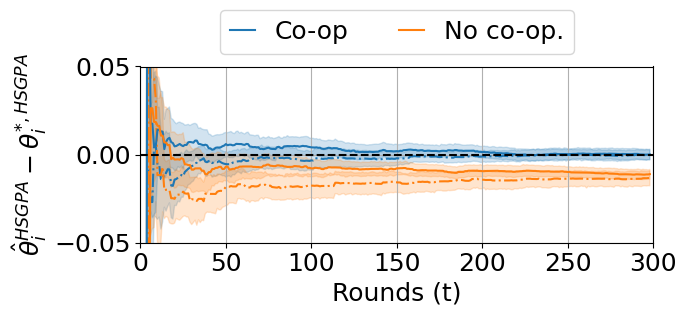

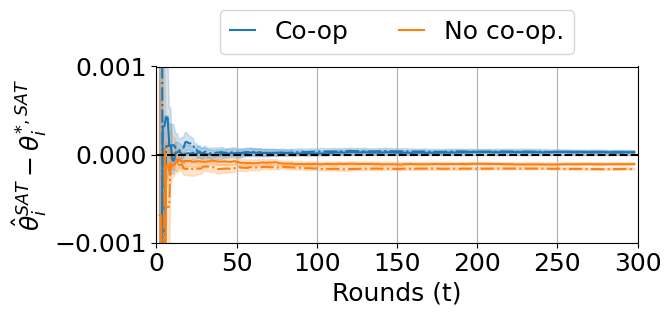

In [28]:
plot_convergence(
    df, 'err_dim1', (-.05, .05), r'$\hat{\theta}^{HS GPA}_{i} - \theta^{*, HS GPA}_{i}$',
    0, pathname='figures/protocol-vs-no-protocol4.pdf'
    )
plot_convergence(
    df=df, y_col='err_dim0', y_range=(-.001, .001),
    y_label=r'$\hat{\theta}^{SAT}_{i} - \theta^{*, SAT}_{i}$',
    hline_y= 0, pathname='figures/protocol-vs-no-protocol3.pdf'
    )

## protocol improvement 

### <font color='red'>compute cell</font>

In [29]:
theta_star_std = .1 # set to 0 for the same underlying causal parameters.
_runs = []
n_envs = 3
coop_envs = (3, 2)
for nce  in tqdm.tqdm(coop_envs):
    cmd = (f"--offline-eval --num-applicants 500000 --applicants-per-round 5000 --scaled-duplicates sequence "
    f"--fixed-effort-conversion --normalize --methods ours --num-envs {n_envs} --theta-star-std {theta_star_std} "
    f"--envs-accept-rates .5 --num-cooperative-envs {nce}")
    args = algos.get_args(cmd)
    n_runs = 100  
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(algos.run_multi_env, args_list )
        _runs.append(runs)


  0%|          | 0/2 [00:00<?, ?it/s]

1it [00:00,  1.00it/s]
1it [00:01,  1.12s/it]
1it [00:01,  1.82s/it]
1it [00:01,  1.47s/it]
1it [00:01,  1.48s/it]
1it [00:01,  1.42s/it]
1it [00:01,  1.86s/it]
1it [00:01,  1.67s/it]
1it [00:01,  1.41s/it]
1it [00:01,  1.69s/it]
1it [00:01,  1.71s/it]
1it [00:01,  1.50s/it]
1it [00:01,  1.18s/it]
1it [00:01,  1.56s/it]
1it [00:01,  1.90s/it]
1it [00:01,  1.38s/it]
1it [00:01,  1.04s/it]
1it [00:01,  1.72s/it]
1it [00:01,  1.66s/it]
1it [00:01,  1.50s/it]
1it [00:01,  1.42s/it]
1it [00:01,  1.48s/it]
1it [00:01,  1.10s/it]
1it [00:01,  1.15s/it]
1it [00:01,  1.09s/it]
1it [00:01,  1.25s/it]
1it [00:01,  1.47s/it]
1it [00:01,  1.50s/it]
1it [00:01,  1.50s/it]
1it [00:01,  1.63s/it]
1it [00:01,  1.81s/it]
1it [00:01,  1.40s/it]
1it [00:00,  1.01it/s]
1it [00:01,  1.69s/it]
1it [00:01,  1.84s/it]
1it [00:01,  1.20s/it]
1it [00:01,  1.66s/it]
1it [00:01,  1.56s/it]
1it [00:01,  1.81s/it]
1it [00:01,  1.20s/it]
1it [00:01,  1.62s/it]
1it [00:01,  1.44s/it]
1it [00:01,  1.98s/it]
1it [00:01,

In [30]:
# some post-processing to save some disk space upon saving. 
dfs = []
for i, nce in enumerate((coop_envs)):
  df = algos.runs2df([r[0] for r in _runs[i]])
  df['cooperative envs.'] = r'Full Cooperation' if nce == 3 else r'Partial Cooperation'
  dfs.append(df)
df = pd.concat(dfs)
df['ours_env0+ours_env1'] = (df['ours_env0'] + df['ours_env1']) / 2.
df 

try:
    save_runs('experiments', 'protocol-improvement', df, args)
except FileExistsError:
    pass


### <font color='blue'>load cell</font>

In [32]:
with open(os.path.join(exp_dir_load, 'protocol-improvement', 'results'), 'rb') as f:
    df = pickle.load(f)

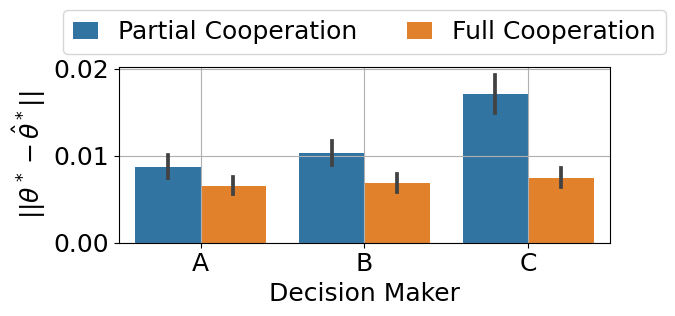

In [33]:
value_vars= (f'ours_env{i}' for i in range(3))
dflong = pd.melt(df, id_vars=('iterations', 'cooperative envs.'), value_vars=value_vars, var_name='env', value_name='error' )
dflong 

rename_cats_args = {f'ours_env{env_idx}': f'${env_idx+1}$' for env_idx in range(3)}
dflong['env']=dflong.env.astype('category').cat.rename_categories(rename_cats_args)
dflong 
fig,ax=plt.subplots(figsize=(7,3.5))
sns.barplot(dflong, x='env', hue='cooperative envs.', y='error', 
            palette={'Full Cooperation': sns.color_palette()[1], 'Partial Cooperation': sns.color_palette()[0]},
            hue_order=('Partial Cooperation', 'Full Cooperation'))
# ax.legend(bbox_to_anchor=(1,1), title='cooperative envs.')
ax.grid() 
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}^*||$')
ax.set_xlabel('Decision Maker')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], ncol=2, loc='lower center', bbox_to_anchor=(0.5, 1), handlelength=1, labelspacing =0)
ax.set_xticklabels(('A', 'B', 'C'))

plt.tight_layout()
plt.savefig('figures/protocol-vs-no-protocol-group.pdf')

# utility experiments

### <font color='red'>compute cell</font>

In [34]:
cmd =(f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence '
       '--fixed-effort-conversion --normalize --methods ols ours --envs-accept-rate .5 --theta-star-std 0')
cmd = f'{cmd} --offline-eval'

args = algos.get_args(cmd)
combos = [
    ('theta_ao_hat', ),
    ('theta_star_hat', ),
    ('theta_ols_hat', )
]

dfs = []
for combo in combos:
    n_runs = 100 
    args_list = [(args, t, combo) for t in range(n_runs)]
    with Pool(n_runs) as p:
        results = p.starmap(algos.run_multi_env_utility, args_list)

    results = [r[0] for r in results] # filtering out the test theta array.
    results = np.array(results)
    pd_dict = {f'perf_env{env_idx}': results[:, env_idx] for env_idx in range(args.num_envs)}
    pd_dict.update(
        {f'test_theta_env{env_idx}': combo[env_idx] for env_idx in range(args.num_envs) }
    )
    df = pd.DataFrame(data=pd_dict)
    dfs.append(df )
df = pd.concat(dfs)

try:
  save_runs('experiments', 'utility-single-env', df, args)
except FileExistsError:
  pass

1it [00:00,  2.73it/s]
1it [00:00,  1.87it/s]
1it [00:00,  1.32it/s]
1it [00:00,  1.24it/s]
1it [00:01,  1.05s/it]
1it [00:00,  1.25it/s]
1it [00:01,  1.04s/it]
1it [00:01,  1.15s/it]
1it [00:00,  1.29it/s]
1it [00:01,  1.13s/it]
1it [00:01,  1.02s/it]
1it [00:01,  1.38s/it]
1it [00:01,  1.34s/it]
1it [00:01,  1.56s/it]
1it [00:01,  1.61s/it]
1it [00:00,  1.13it/s]
1it [00:00,  1.50it/s]
1it [00:00,  1.51it/s]
1it [00:00,  1.21it/s]
1it [00:01,  1.64s/it]
1it [00:01,  1.15s/it]
1it [00:00,  1.33it/s]
1it [00:00,  1.57it/s]
1it [00:01,  1.10s/it]
1it [00:00,  1.39it/s]
1it [00:00,  1.36it/s]
1it [00:00,  1.35it/s]
1it [00:00,  1.41it/s]
1it [00:00,  1.43it/s]
1it [00:00,  1.22it/s]
1it [00:00,  1.43it/s]
1it [00:00,  1.61it/s]
1it [00:00,  1.42it/s]
1it [00:00,  1.66it/s]
1it [00:00,  1.63it/s]
1it [00:00,  1.33it/s]
1it [00:00,  1.81it/s]
1it [00:00,  1.86it/s]
1it [00:00,  1.71it/s]
1it [00:00,  2.31it/s]
1it [00:00,  2.56it/s]
1it [00:00,  2.63it/s]
1it [00:00,  2.82it/s]
1it [00:00,


### <font color='blue'>load cell</font>

In [36]:
with open(os.path.join(exp_dir_load, 'utility-single-env', 'results'), 'rb') as f:
    df =pickle.load(f)

perf_env0          
                     mean       sem
test_theta_env0                    
theta_ao_hat     2.530418  0.006422
theta_ols_hat    2.511824  0.006323
theta_star_hat   2.511641  0.006336

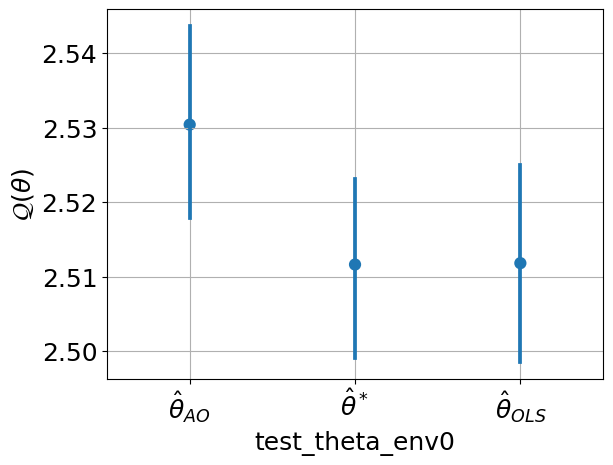

In [37]:
fig,ax=plt.subplots()
sns.pointplot(df, y='perf_env0', x='test_theta_env0', join=False)
ax.set_ylabel(r'$\mathcal{Q}(\theta)$')
ax.set_xticklabels(labels=[r'$\hat{\theta}_{AO}$', r'$\hat{\theta}^*$', r'$\hat{\theta}_{OLS}$'])
ax.grid() 

df_test = df.groupby('test_theta_env0').agg(('mean', 'sem'))
df_test 

In [29]:
# # inspecting the thetas.
# cmd =(f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence '
       # '--fixed-effort-conversion --normalize --methods ols ours --envs-accept-rate .5')
# cmd = f'{cmd} --offline-eval'

# args = algos.get_args(cmd)
# record = {}
# for t in ('theta_ao_hat', 'theta_ols_hat', 'theta_star_hat'):
       # _, test_theta = algos.run_multi_env_utility(args, seed=1, test_theta_envs=(t, ))
       # record[t] = test_theta.flatten()
# record

1it [00:00,  3.78it/s]
1it [00:00,  3.81it/s]
1it [00:00,  3.73it/s]


{'theta_ao_hat': array([0.0887437 , 0.49812076]),
 'theta_ols_hat': array([0.00067174, 0.50596371]),
 'theta_star_hat': array([-8.63343972e-05,  5.05964152e-01])}

# utility exps. (multiple envs.)


### <font color='red'>compute cell</font>

In [38]:
theta_star_std = 0.1 # set to 0 for the same underlying causal parameters per environment. 
from itertools import  product
options = ('theta_ao_hat', 'theta_ols_hat', 'theta_star_hat')
combos = [x for x in product(options, options)]

cmd = (f"--num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence "
       f"--fixed-effort-conversion --normalize --methods ours ols --num-envs 2 --theta-star-std {theta_star_std} "
       f"--envs-accept-rates .5 --num-cooperative-envs 2")
cmd = f'{cmd} --offline-eval'
args =algos.get_args(cmd)

In [39]:
dfs = []
for combo in tqdm.tqdm(combos):
    n_runs = 100
    args_list = [(args, t, combo) for t in range(n_runs)]
    with Pool(n_runs) as p:
        results = p.starmap(algos.run_multi_env_utility, args_list)

    results = [r[0] for r in results] # filtering out the test theta array.
    results = np.array(results)
    pd_dict = {f'perf_env{env_idx}': results[:, env_idx] for env_idx in range(args.num_envs)}
    pd_dict.update(
        {f'test_theta_env{env_idx}': combo[env_idx] for env_idx in range(args.num_envs) }
    )
    df = pd.DataFrame(data=pd_dict)
    dfs.append(df )

df = pd.concat(dfs)
try:
  save_runs('experiments', 'utility-multi-env', df, args)
except FileExistsError:
  pass

  0%|          | 0/9 [00:00<?, ?it/s]

1it [00:05,  5.95s/it]
1it [00:05,  5.84s/it]
1it [00:05,  5.60s/it]
1it [00:06,  6.04s/it]
1it [00:05,  5.80s/it]
1it [00:00,  4.83it/s]
1it [00:05,  5.38s/it]
1it [00:06,  6.00s/it]
1it [00:06,  6.06s/it]
1it [00:00,  4.53it/s]
1it [00:05,  5.95s/it]
1it [00:00,  4.68it/s]
1it [00:00,  4.55it/s]
1it [00:05,  5.63s/it]
1it [00:05,  5.71s/it]
1it [00:00,  4.54it/s]
1it [00:05,  5.91s/it]
1it [00:00,  4.55it/s]
1it [00:00,  4.48it/s]
1it [00:00,  3.95it/s]
1it [00:05,  5.62s/it]
1it [00:05,  5.60s/it]
1it [00:00,  4.82it/s]
1it [00:05,  5.95s/it]
1it [00:00,  3.82it/s]
1it [00:05,  5.83s/it]
1it [00:00,  4.73it/s]
1it [00:05,  5.31s/it]
1it [00:00,  4.60it/s]
1it [00:05,  5.40s/it]
1it [00:05,  5.70s/it]
1it [00:05,  5.25s/it]
1it [00:05,  5.63s/it]
1it [00:05,  5.60s/it]
1it [00:05,  5.87s/it]
1it [00:00,  4.67it/s]
1it [00:00,  4.47it/s]
1it [00:00,  4.49it/s]
1it [00:00,  4.78it/s]
1it [00:05,  5.71s/it]
1it [00:05,  5.46s/it]
1it [00:00,  4.75it/s]
1it [00:05,  5.82s/it]
1it [00:05,


### <font color='blue'>load cell</font>

In [41]:
with open(os.path.join(exp_dir_load, 'utility-multi-env', 'results'), 'rb') as f:
    df = pickle.load(f)

In [42]:
df['test_theta_env0'] = df['test_theta_env0'].astype('category')
df['test_theta_env1'] = df['test_theta_env1'].astype('category')
pd.melt(df, id_vars='perf_env0', value_vars=('test_theta_env0', 'test_theta_env1'))
df 
df_ = df[['perf_env0', 'test_theta_env0', 'test_theta_env1']]

df_['test_theta_env1'] = df_['test_theta_env1'].cat.rename_categories(
    {
        'theta_ao_hat': r'$\hat{\theta}^{AO}_2$',
        'theta_star_hat': r'$\hat{\theta}^*_2$',
        'theta_ols_hat': r'$\hat{\theta}_{OLS}$'
        }
)
df_ = df_.rename(columns={'test_theta_env1': r'$\theta_{2t}$'})
df_ 

df_test = df_.groupby([r'$\theta_{2t}$', 'test_theta_env0' ]).agg(['mean', 'sem'])
df_test 

/home/maadil/anaconda3/envs/strategic-iv/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


perf_env0          
                                           mean       sem
$\theta_{2t}$         test_theta_env0                    
$\hat{\theta}^{AO}_2$ theta_ao_hat     2.529628  0.028585
                      theta_ols_hat    2.507007  0.029328
                      theta_star_hat   2.506565  0.029368
$\hat{\theta}_{OLS}$  theta_ao_hat     2.561507  0.028920
                      theta_ols_hat    2.546711  0.029447
                      theta_star_hat   2.545568  0.029306
$\hat{\theta}^*_2$    theta_ao_hat     2.560883  0.029135
                      theta_ols_hat    2.546165  0.029399
                      theta_star_hat   2.544858  0.029180